In [2]:
''' In this ipynb file, features are extracted from both the trained CNN ResNet-18 Model and the pretrained ImageNet CNN from pytorch,
    and then used to train a Logistic Regression model, and then a k-nearest neighbors
    model. Acuraccy, precision, etc. and confusion matrix are shown for both.
'''
from PIL import Image
import numpy as np
import os
import torch
import torchvision
import torchvision.models as models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision import transforms

In [3]:
# To connect to the drive where the datasets are present
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Download datatset #2 & #3
dataset3_path = "/content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/Dataset 3/Animal Faces"
dataset2_path = "/content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/Dataset 2/Prostate Cancer"
# Define basic transform function
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset3 = torchvision.datasets.ImageFolder(root=dataset3_path, transform = data_transform)
dataset2 = torchvision.datasets.ImageFolder(root=dataset2_path, transform = data_transform)

In [5]:
# Defining the ResNet-18 Model
import torch.nn as nn
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer (conv1)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer (conv2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (if needed)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)

        return out


#
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

print('done')

done


In [6]:
model = ResNet18(3)
print('done')

done


In [7]:
# Loading the ResNet-18 model
model_name_to_load = 'model.pth'
# save_dir=F"C:/Users/bl/Documents/Comp432/ProjectGroupP/{model_name_to_load}"
# save_dir=F"C:/Users/bl/Documents/Comp432/ProjectGroupP/best/{model_name_to_load}"
save_dir=F"/content/drive/MyDrive/Comp 432 Project/COMP432-GroupP/{model_name_to_load}"

state_dict = torch.load(save_dir)
model.load_state_dict(state_dict)

print('done')

done


In [12]:
# Defining the t-SNE extraction functions & the preprocessing functions
model.eval()

def preprocess_dataset_2(directory_path):
    categories = ['gland', 'nongland', 'tumor']
    processed_images = []
    allowed_extensions = {'jpg', 'jpeg', 'png', 'bmp', 'gif'}
    for category in categories:
        folder_path = os.path.join(directory_path, category)
        for image_file in os.listdir(folder_path):
            if image_file.split('.')[-1].lower() in allowed_extensions:
                image_path = os.path.join(folder_path, image_file)
                with Image.open(image_path) as img:
                    img_resized = img.resize((224, 224))
                    img_array = np.asarray(img_resized) / 255.0
                    processed_images.append((img_array, category))
    return processed_images

def preprocess_dataset_3(directory_path):
    categories = ['cat', 'dog', 'wild']
    processed_images = []
    allowed_extensions = {'jpg', 'jpeg', 'png', 'bmp', 'gif'}

    for category in categories:
        folder_path = os.path.join(directory_path, category)
        for image_file in os.listdir(folder_path):
            if image_file.split('.')[-1].lower() in allowed_extensions:
                image_path = os.path.join(folder_path, image_file)
                with Image.open(image_path) as img:
                    img_resized = img.resize((224, 224))
                    img_array = np.asarray(img_resized) / 255.0
                    processed_images.append((img_array, category))
    return processed_images



def extract_features(preprocessed_images):
    count = 0
    features = []
    labels = []
    for img_array, category in preprocessed_images:
        image_tensor = torch.tensor(img_array).unsqueeze(0).permute(0, 3, 1, 2)
        with torch.no_grad():
            feature = model(image_tensor.float())
        features.append(feature.flatten().numpy())
        labels.append(category)
        count+=1
        # if(count%20==0):
        #   print(count)
    return np.array(features), labels


def visualize_features(features, labels):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_features = tsne.fit_transform(features)

    unique_labels = list(set(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    plt.figure(figsize=(8, 8))
    for i, label in enumerate(unique_labels):
        indices = [j for j, x in enumerate(labels) if x == label]
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], color=colors[i], label=label)
    plt.legend()
    plt.title("Feature Visualization with t-SNE")
    plt.show()

In [ ]:
# Preprocess Dataset #2 before extracting features from the ResNet-18 Model
dataset_2_processed = preprocess_dataset_2(dataset2_path)


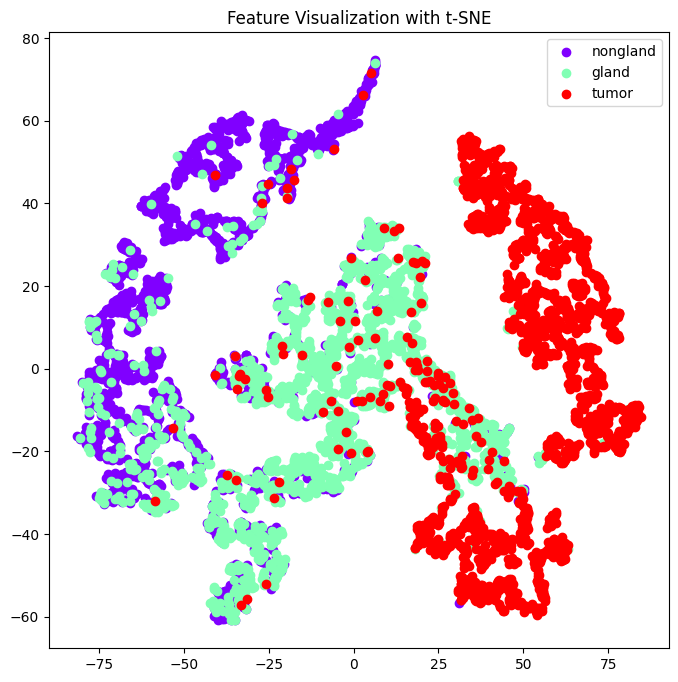

In [ ]:
# feature extraction for Dataset #2 from the ResNet-18 Model
features, labels = extract_features(dataset_2_processed)
visualize_features(features, labels)

In [14]:
# Preprocess Dataset #3 before extracting features from the ResNet-18 Model
dataset_3_processed = preprocess_dataset_3(dataset3_path)

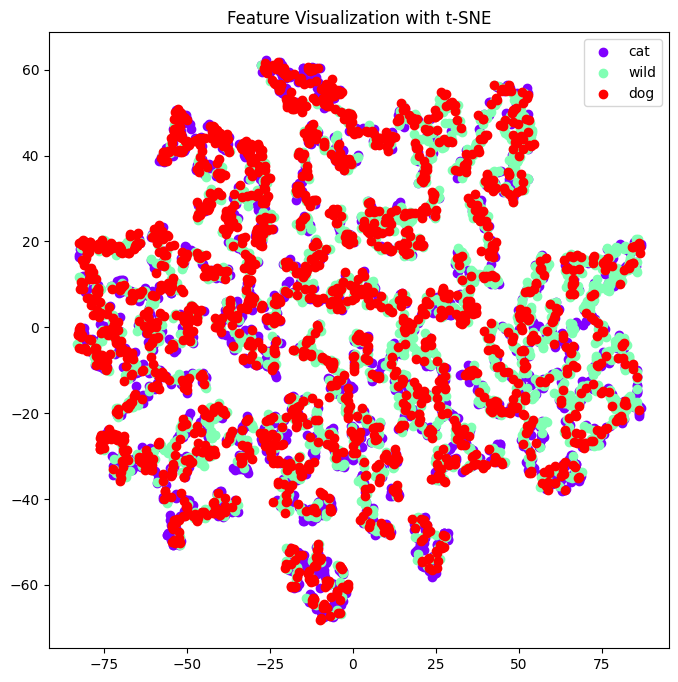

In [ ]:
# feature extraction for Dataset #3 from the ResNet-18 Model
features, labels = extract_features(dataset_3_processed)
visualize_features(features, labels)

In [ ]:
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50 = torch.nn.Sequential(*(list(model_resnet50.children())[:-1]))
model_resnet50.eval()


In [10]:
def extract_features_resent50(preprocessed_images):
    count = 0
    features = []
    labels = []
    for img_array, category in preprocessed_images:
        image_tensor = torch.tensor(img_array).unsqueeze(0).permute(0, 3, 1, 2)
        with torch.no_grad():
            feature = model_resnet50(image_tensor.float())
        features.append(feature.flatten().numpy())
        labels.append(category)
        count+=1
        # if(count%20==0):
        #   print(count)
    return np.array(features), labels

def visualize_features_resnet50(features, labels):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_features = tsne.fit_transform(features)

    unique_labels = list(set(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    plt.figure(figsize=(8, 8))
    for i, label in enumerate(unique_labels):
        indices = [j for j, x in enumerate(labels) if x == label]
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], color=colors[i], label=label)
    plt.legend()
    plt.title("Feature Visualization with t-SNE")
    plt.show()



In [ ]:
features, labels = extract_features_resent50(dataset_2_processed)
visualize_features_resnet50(features, labels)

In [ ]:
features, labels = extract_features_resent50(dataset_3_processed)
visualize_features_resnet50(features, labels)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Encode the labels into numbers for training
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# shuffle
indices = np.arange(len(features))
np.random.shuffle(indices)
shuffled_features = features[indices]
shuffled_labels = encoded_labels[indices]

In [ ]:
# Training LR on the extracted features
X_train, X_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.2, random_state=0)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Testing
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.48
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.37      0.41       397
           1       0.49      0.48      0.49       395
           2       0.49      0.60      0.54       412

    accuracy                           0.48      1204
   macro avg       0.48      0.48      0.48      1204
weighted avg       0.48      0.48      0.48      1204



In [ ]:
from sklearn.metrics import confusion_matrix
# Confusion matrix
def plot_confusion_matrix(y_test, y_pred, title):
  # decode the labels back into words for display
  y_test_decoded = label_encoder.inverse_transform(y_test)
  y_pred_decoded = label_encoder.inverse_transform(y_pred)

  conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

  plt.figure(figsize=(8, 6))
  plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()

  classes = np.unique(np.concatenate((y_test_decoded, y_pred_decoded)))
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black', fontsize=12)

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

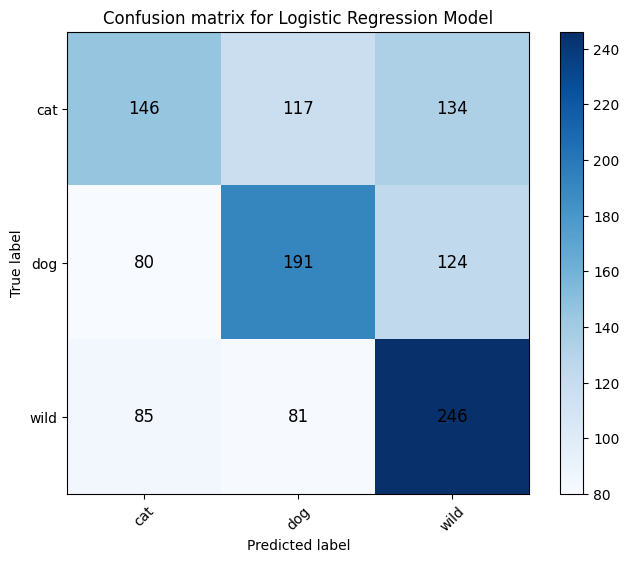

In [ ]:
plot_confusion_matrix(y_test, y_pred, 'Confusion matrix for Logistic Regression Model')

In [ ]:
# Now, let's fit the same features to a k-nearest neighbors clustering model
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

# Testing
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.39
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.51      0.42       397
           1       0.41      0.34      0.37       395
           2       0.43      0.33      0.37       412

    accuracy                           0.39      1204
   macro avg       0.40      0.39      0.39      1204
weighted avg       0.40      0.39      0.39      1204



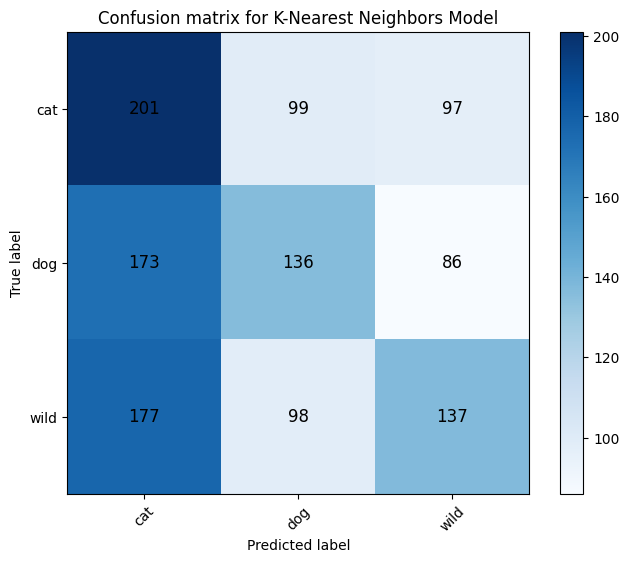

In [ ]:
plot_confusion_matrix(y_test, y_pred, 'Confusion matrix for K-Nearest Neighbors Model')